In [3]:
import json

class QLearningAgent:
    def __init__(self):
        self.flag = 1
        self.discount_factor = 0.95
        self.alpha = 0.5
        #self.alpha_decay = 0.00003
        self.generation = 0
        self.prev_action = 0
        self.prev_state = "0_0_0_0"
        self.moves = []
        self._Qvalues = {}
        self.max_len = 1000000
        #self.load_qvalues()
    def load_qvalues(self):
        print("Loading Q-table states from json file...")
        try:
            with open("data/_Qvalues_resume.json", "r") as f:
                self._Qvalues = json.load(f)
        except IOError:
            self.init_qvalues(self.prev_state)
    
    def get_max_Qvalue(self, state):
        return max(self._Qvalues[state][0], self._Qvalues[state][1])

    def update(self, state, new_state, action, reward):
        if (self.flag):
            self._Qvalues[state][action] = (1 - self.alpha) * (self._Qvalues[state][action]) + \
            self.alpha * (reward + self.discount_factor * self.get_max_Qvalue(new_state))

    def init_qvalues(self, state):
        if self._Qvalues.get(state) is None:
            self._Qvalues[state] = [0, 0]

    def getAction(self, state):
        if (self.flag):
            self.moves.append((self.prev_state, self.prev_action, state))
            if (len(self.moves) > self.max_len):
                all_moves = list(reversed(self.moves))
                for i in range(self.max_len):
                    state, action, new_state = all_moves[i]
                    self.update(state, new_state, action, 0)
                self.moves = self.moves[self.max_len:]
            self.prev_state = state
        if (self._Qvalues[state][0] >= self._Qvalues[state][1]):
            self.prev_action = 0
        else:
            self.prev_action = 1
        return self.prev_action

    def update_all_Qvalues(self):
        if (self.flag):
            death_flag = 0
            if (int(self.moves[len(self.moves) - 1][2].split("_")[1]) > 120):
                death_flag = 1
            for i in range(len(self.moves) - 1, 0,  -1):
                state, action, new_state = self.moves[i]
                reward = 0
                if (i >= len(self.moves) - 2):
                    reward = -1000
                elif ((death_flag) and action):
                    death_flag = 0
                    reward = -1000
                self.update(state, new_state, action, reward)
            self.moves = []
    def get_x_coordinate(self, x):
        if (x < -40):
            return int(x)
        elif (x < 140):
            return int(x) - (int(x) % 10)
        else:
            return int(x) - (int(x) % 70)
        
    def get_y_coordinate(self, y):
        if (-180 < y < 180):
            return int(y) - (int(y) % 10)
        return int(y) - (int(y) % 60)
    
    def get_state(self, x, y, vel, pipe):
        pipe1 = pipe[0]
        pipe2 = pipe[1]
        if (x - pipe[0]["x"] >= 50):
            pipe1 = pipe[1]
            if (len(pipe) > 2):
                pipe2 = pipe[2]

        x1 = pipe1["x"] - x
        y1 = pipe1["y"] - y

        if (-50 < x1 <= 0):
            y2 = pipe1["y"] - y
        else:
            y2 = 0
        
        x1 = self.get_x_coordinate(x1)
        y1 = self.get_y_coordinate(y1)
        y2 = self.get_y_coordinate(y2)
        state = str(int(x1)) + "_" + str(int(y1)) + "_" + str(int(vel))
        self.init_qvalues(state)
        return state

    def save_qvalues(self):
        if self.flag:
            with open("data/_Qvalues_resume.json", "w") as f:
                json.dump(self._Qvalues, f)


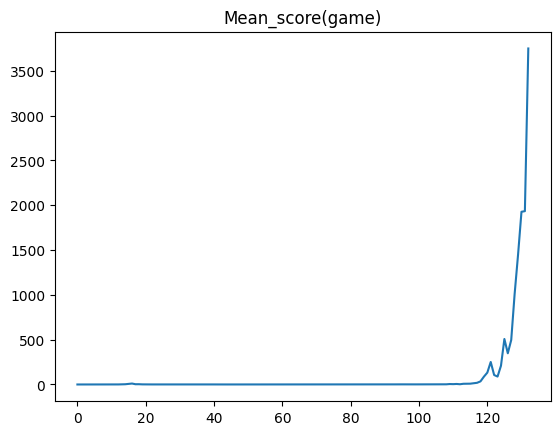

KeyboardInterrupt: 

In [4]:
import matplotlib.pyplot as plt
from itertools import cycle
from collections import deque
import copy
import random
import sys
import pygame
from pygame.locals import *
from IPython.display import clear_output

#from qlearning import QLearningAgent

FPS = 10000
SCREENWIDTH = 288
SCREENHEIGHT = 512
PIPEGAPSIZE = 100
BASEY = SCREENHEIGHT * 0.79
IMAGES, SOUNDS, HITMASKS = {}, {}, {}
episodes = [0]
max_score = [0]
Check = [0]
scores = []
cur_score = [0]
PLAYERS_LIST = (
    # red bird
    (
        'assets/sprites/redbird-upflap.png',
        'assets/sprites/redbird-midflap.png',
        'assets/sprites/redbird-downflap.png',
    ),
    # blue bird
    (
        'assets/sprites/bluebird-upflap.png',
        'assets/sprites/bluebird-midflap.png',
        'assets/sprites/bluebird-downflap.png',
    ),
    # yellow bird
    (
        'assets/sprites/yellowbird-upflap.png',
        'assets/sprites/yellowbird-midflap.png',
        'assets/sprites/yellowbird-downflap.png',
    ),
)

# list of backgrounds
BACKGROUNDS_LIST = (
    'assets/sprites/background-day.png',
    'assets/sprites/background-night.png',
)

# list of pipes
PIPES_LIST = (
    'assets/sprites/pipe-green.png',
    'assets/sprites/pipe-red.png',
)

try:
    xrange
except NameError:
    xrange = range

agent = QLearningAgent()

def main():
    global SCREEN, FPSCLOCK
    pygame.init()
    FPSCLOCK = pygame.time.Clock()
    SCREEN = pygame.display.set_mode((SCREENWIDTH, SCREENHEIGHT))
    pygame.display.set_caption('Flappy Bird')

    # numbers sprites for score display
    IMAGES['numbers'] = (
        pygame.image.load('assets/sprites/0.png').convert_alpha(),
        pygame.image.load('assets/sprites/1.png').convert_alpha(),
        pygame.image.load('assets/sprites/2.png').convert_alpha(),
        pygame.image.load('assets/sprites/3.png').convert_alpha(),
        pygame.image.load('assets/sprites/4.png').convert_alpha(),
        pygame.image.load('assets/sprites/5.png').convert_alpha(),
        pygame.image.load('assets/sprites/6.png').convert_alpha(),
        pygame.image.load('assets/sprites/7.png').convert_alpha(),
        pygame.image.load('assets/sprites/8.png').convert_alpha(),
        pygame.image.load('assets/sprites/9.png').convert_alpha()
    )

    IMAGES['gameover'] = pygame.image.load('assets/sprites/gameover.png').convert_alpha()
    # message sprite for welcome screen
    IMAGES['message'] = pygame.image.load('assets/sprites/message.png').convert_alpha()
    # base (ground) sprite
    IMAGES['base'] = pygame.image.load('assets/sprites/base.png').convert_alpha()

    # sounds
    if 'win' in sys.platform:
        soundExt = '.wav'
    else:
        soundExt = '.ogg'

    SOUNDS['die'] = pygame.mixer.Sound('assets/audio/die' + soundExt)
    SOUNDS['hit'] = pygame.mixer.Sound('assets/audio/hit' + soundExt)
    SOUNDS['point'] = pygame.mixer.Sound('assets/audio/point' + soundExt)
    SOUNDS['swoosh'] = pygame.mixer.Sound('assets/audio/swoosh' + soundExt)
    SOUNDS['wing'] = pygame.mixer.Sound('assets/audio/wing' + soundExt)
    iter = 5000

    while iter != 0:
        iter -= 1
        # select random background sprites
        randBg = random.randint(0, len(BACKGROUNDS_LIST) - 1)
        IMAGES['background'] = pygame.image.load(BACKGROUNDS_LIST[randBg]).convert()

        # select random player sprites
        randPlayer = random.randint(0, len(PLAYERS_LIST) - 1)
        IMAGES['player'] = (
            pygame.image.load(PLAYERS_LIST[randPlayer][0]).convert_alpha(),
            pygame.image.load(PLAYERS_LIST[randPlayer][1]).convert_alpha(),
            pygame.image.load(PLAYERS_LIST[randPlayer][2]).convert_alpha(),
        )

        # select random pipe sprites
        pipeindex = random.randint(0, len(PIPES_LIST) - 1)
        IMAGES['pipe'] = (
            pygame.transform.flip(
                pygame.image.load(PIPES_LIST[pipeindex]).convert_alpha(), False, True),
            pygame.image.load(PIPES_LIST[pipeindex]).convert_alpha(),
        )

        # hismask for pipes
        HITMASKS['pipe'] = (
            getHitmask(IMAGES['pipe'][0]),
            getHitmask(IMAGES['pipe'][1]),
        )

        # hitmask for player
        HITMASKS['player'] = (
            getHitmask(IMAGES['player'][0]),
            getHitmask(IMAGES['player'][1]),
            getHitmask(IMAGES['player'][2]),
        )

        movementInfo = showWelcomeAnimation()
        mainGame(movementInfo)
        # if (Check[0]):
        #     break
        #showGameOverScreen(crashInfo)
        agent.save_qvalues()
        clear_output(True)
        plt.plot(scores)
        plt.title("Mean_score(game)")
        plt.show()
    
    

def showWelcomeAnimation():
    """Shows welcome screen animation of flappy bird"""
    # index of player to blit on screen
    playerIndex = 0
    playerIndexGen = cycle([0, 1, 2, 1])
    # iterator used to change playerIndex after every 5th iteration
    loopIter = 0

    playerx = int(SCREENWIDTH * 0.2)
    playery = int((SCREENHEIGHT - IMAGES['player'][0].get_height()) / 2)

    messagex = int((SCREENWIDTH - IMAGES['message'].get_width()) / 2)
    messagey = int(SCREENHEIGHT * 0.12)

    basex = 0
    # amount by which base can maximum shift to left
    baseShift = IMAGES['base'].get_width() - IMAGES['background'].get_width()

    # player shm for up-down motion on welcome screen
    playerShmVals = {'val': 0, 'dir': 1}
    return {
                    'playery': playery + playerShmVals['val'],
                    'basex': basex,
                    'playerIndexGen': playerIndexGen,
            }

def mainGame(movementInfo):
    score = playerIndex = loopIter = 0
    playerIndexGen = movementInfo['playerIndexGen']
    playerx, playery = int(SCREENWIDTH * 0.2), movementInfo['playery']

    basex = movementInfo['basex']
    baseShift = IMAGES['base'].get_width() - IMAGES['background'].get_width()

    newPipe1 = getRandomPipe()
    newPipe2 = getRandomPipe()

    upperPipes = [
        {'x': SCREENWIDTH + 200, 'y': newPipe1[0]['y']},
        {'x': SCREENWIDTH + 200 + (SCREENWIDTH / 2), 'y': newPipe2[0]['y']},
    ]

    lowerPipes = [
        {'x': SCREENWIDTH + 200, 'y': newPipe1[1]['y']},
        {'x': SCREENWIDTH + 200 + (SCREENWIDTH / 2), 'y': newPipe2[1]['y']},
    ]

    pipeVelX = -4

    playerVelY = -9
    playerMaxVelY = 10
    playerMinVelY = -8
    playerAccY = 1
    playerFlapAcc = -9
    playerFlapped = False
    while True:
        state = agent.get_state(playerx, playery, playerVelY, lowerPipes)
        if agent.getAction(state):
            if playery > -2 * IMAGES['player'][0].get_height():
                playerVelY = playerFlapAcc
                playerFlapped = True

        crashTest = checkCrash({'x': playerx, 'y': playery, 'index': playerIndex},
                               upperPipes, lowerPipes)
        if crashTest[0]:
            agent.update_all_Qvalues()
            max_score[0] = max(max_score[0], score)
            episodes[0] += 1
            #scores.append(score)
            cur_score[0] += score
            if (episodes[0] % 30 == 0):
                scores.append(cur_score[0] / 30)
                cur_score[0] = 0
                print(f"Episode: {episodes[0]}, score: {score}, max_score: {max_score[0]}")
            #print(f"Episode: {episodes[0]}, score: {score}, max_score: {max_score[0]}")
            return {
                'y': playery,
                'groundCrash': crashTest[1],
                'basex': basex,
                'upperPipes': upperPipes,
                'lowerPipes': lowerPipes,
                'score': score,
                'playerVelY': playerVelY,
            }

        playerMidPos = playerx + IMAGES['player'][0].get_width() / 2
        for pipe in upperPipes:
            pipeMidPos = pipe['x'] + IMAGES['pipe'][0].get_width() / 2
            if pipeMidPos <= playerMidPos < pipeMidPos + 4:
                score += 1

        # if (score >= 8000):
        #     Check[0] = 1
        #     print(score)
        #     print("ACCEPTED")
        #     return {
        #         'y': playery,
        #         'groundCrash': crashTest[1],
        #         'basex': basex,
        #         'upperPipes': upperPipes,
        #         'lowerPipes': lowerPipes,
        #         'score': score,
        #         'playerVelY': playerVelY,
        #     }

        if (loopIter + 1) % 3 == 0:
            playerIndex = next(playerIndexGen)
        loopIter = (loopIter + 1) % 30
        basex = -((-basex + 100) % baseShift)

        if playerVelY < playerMaxVelY and not playerFlapped:
            playerVelY += playerAccY
        if playerFlapped:
            playerFlapped = False

        playerHeight = IMAGES['player'][playerIndex].get_height()
        playery += min(playerVelY, BASEY - playery - playerHeight)

        for uPipe, lPipe in zip(upperPipes, lowerPipes):
            uPipe['x'] += pipeVelX
            lPipe['x'] += pipeVelX

        if 0 < upperPipes[0]['x'] < 5:
            newPipe = getRandomPipe()
            upperPipes.append(newPipe[0])
            lowerPipes.append(newPipe[1])

        if upperPipes[0]['x'] < -IMAGES['pipe'][0].get_width():
            upperPipes.pop(0)
            lowerPipes.pop(0)

        
        SCREEN.blit(IMAGES['background'], (0, 0))

        for uPipe, lPipe in zip(upperPipes, lowerPipes):
            SCREEN.blit(IMAGES['pipe'][0], (uPipe['x'], uPipe['y']))
            SCREEN.blit(IMAGES['pipe'][1], (lPipe['x'], lPipe['y']))

        SCREEN.blit(IMAGES['base'], (basex, BASEY))
        showScore(score)

        playerSurface = IMAGES['player'][playerIndex]
        SCREEN.blit(playerSurface, (playerx, playery))

        pygame.display.update()
        FPSCLOCK.tick(FPS)

def playerShm(playerShm):
    """oscillates the value of playerShm['val'] between 8 and -8"""
    if abs(playerShm['val']) == 8:
        playerShm['dir'] *= -1

    if playerShm['dir'] == 1:
        playerShm['val'] += 1
    else:
        playerShm['val'] -= 1


def getRandomPipe():
    """returns a randomly generated pipe"""
    # y of gap between upper and lower pipe
    gapY = random.randrange(0, int(BASEY * 0.6 - PIPEGAPSIZE))
    gapY += int(BASEY * 0.2)
    pipeHeight = IMAGES['pipe'][0].get_height()
    pipeX = SCREENWIDTH + 10

    return [
        {'x': pipeX, 'y': gapY - pipeHeight},  # upper pipe
        {'x': pipeX, 'y': gapY + PIPEGAPSIZE},  # lower pipe
    ]


def showScore(score):
    """displays score in center of screen"""
    scoreDigits = [int(x) for x in list(str(score))]
    totalWidth = 0  # total width of all numbers to be printed

    for digit in scoreDigits:
        totalWidth += IMAGES['numbers'][digit].get_width()

    Xoffset = (SCREENWIDTH - totalWidth) / 2

    for digit in scoreDigits:
        SCREEN.blit(IMAGES['numbers'][digit], (Xoffset, SCREENHEIGHT * 0.1))
        Xoffset += IMAGES['numbers'][digit].get_width()


def checkCrash(player, upperPipes, lowerPipes):
    """returns True if player collders with base or pipes."""
    pi = player['index']
    player['w'] = IMAGES['player'][0].get_width()
    player['h'] = IMAGES['player'][0].get_height()

    # if player crashes into ground
    if player['y'] + player['h'] >= BASEY - 1:
        return [True, True]
    else:

        playerRect = pygame.Rect(player['x'], player['y'],
                                 player['w'], player['h'])
        pipeW = IMAGES['pipe'][0].get_width()
        pipeH = IMAGES['pipe'][0].get_height()

        for uPipe, lPipe in zip(upperPipes, lowerPipes):
            # upper and lower pipe rects
            uPipeRect = pygame.Rect(uPipe['x'], uPipe['y'], pipeW, pipeH)
            lPipeRect = pygame.Rect(lPipe['x'], lPipe['y'], pipeW, pipeH)

            # player and upper/lower pipe hitmasks
            pHitMask = HITMASKS['player'][pi]
            uHitmask = HITMASKS['pipe'][0]
            lHitmask = HITMASKS['pipe'][1]

            # if bird collided with upipe or lpipe
            uCollide = pixelCollision(playerRect, uPipeRect, pHitMask, uHitmask)
            lCollide = pixelCollision(playerRect, lPipeRect, pHitMask, lHitmask)

            if uCollide or lCollide:
                return [True, False]

    return [False, False]


def pixelCollision(rect1, rect2, hitmask1, hitmask2):
    """Checks if two objects collide and not just their rects"""
    rect = rect1.clip(rect2)

    if rect.width == 0 or rect.height == 0:
        return False

    x1, y1 = rect.x - rect1.x, rect.y - rect1.y
    x2, y2 = rect.x - rect2.x, rect.y - rect2.y

    for x in xrange(rect.width):
        for y in xrange(rect.height):
            if hitmask1[x1 + x][y1 + y] and hitmask2[x2 + x][y2 + y]:
                return True
    return False


def getHitmask(image):
    """returns a hitmask using an image's alpha."""
    mask = []
    for x in xrange(image.get_width()):
        mask.append([])
        for y in xrange(image.get_height()):
            mask[x].append(bool(image.get_at((x, y))[3]))
    return mask


if __name__ == '__main__':
    main()
